## Lecture 6

In this demonstration, we will explore some components of clustering. Using a dataset about employee surveys, we will divide records into clusters based on shared attributes. 

In [15]:
# importing packages 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import cluster 
from sklearn.metrics import pairwise_distances
from sklearn import metrics

# changing some settings

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)
plt.rcParams['figure.figsize'] = (8,6)

We will look at two approaches to clustering

- partitioning
- hierarchical 

Each approach will allow us to determine shared attributes of records. We will work with the dataset about employee surveys from Lecture 2. The survey asks employees to rank themselves on a scale of 1 to 10 in each of the following areas 

- Visualization 
- Computer Science
- Math 
- Statistics
- Machine Learning 
- Business
- Communication


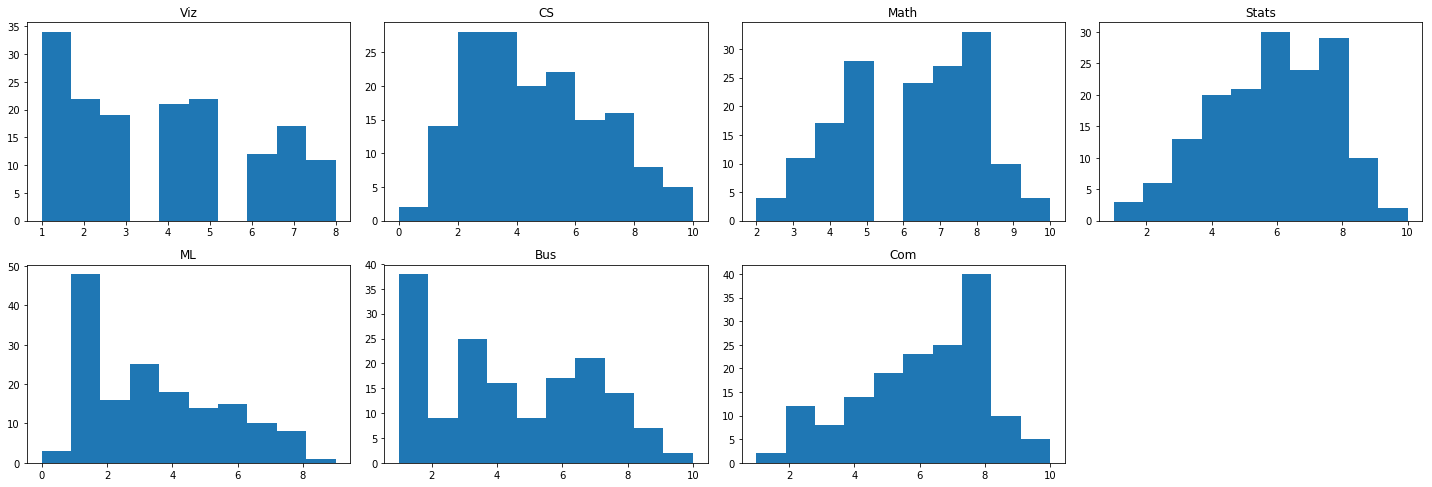

In [7]:
d = pd.read_csv("survey.csv")
dpro = d[['profile_{}'.format(k + 1) for k in range(7)]]
dpro.columns = ['Viz', 'CS', 'Math', 'Stats', 'ML', 'Bus', 'Com']

fig = plt.figure(figsize = (20, 10))
for i in range(7):
    plt.subplot(3, 4, i + 1)
    plt.hist(dpro[dpro.columns.values[i]])
    plt.title(dpro.columns.values[i])

fig.tight_layout()

plt.show()

We can examine the correlation between skills.

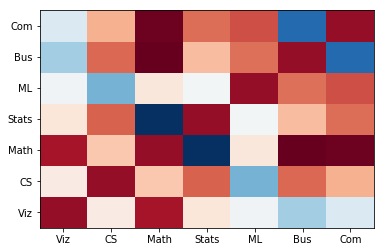

,Viz,CS,Math,Stats,ML,Bus,Com
Viz,0.000000,0.282906,0.015144,0.270820,0.328538,0.437584,0.368496
CS,0.282906,0.000000,0.215316,0.101657,0.481906,0.107712,0.185016
Math,0.015144,0.215316,0.000000,0.670016,0.272858,-0.044132,-0.037995
Stats,0.270820,0.101657,0.670016,0.000000,0.321812,0.201824,0.114225
ML,0.328538,0.481906,0.272858,0.321812,0.000000,0.117302,0.083175
Bus,0.437584,0.107712,-0.044132,0.201824,0.117302,0.000000,0.589699
Com,0.368496,0.185016,-0.037995,0.114225,0.083175,0.589699,0.000000


In [3]:
#Get correlation and 0 out the diagonal (for plotting purposes)
c_mat = dpro.corr()
for i in range(c_mat.shape[0]):
    c_mat.iloc[i,i] = 0

fig, ax = plt.subplots()
heatmap = ax.pcolor(c_mat, cmap=plt.cm.RdBu)

#Set the tick labels and center them
ax.set_xticks(np.arange(c_mat.shape[0])+0.5, minor=False)
ax.set_yticks(np.arange(c_mat.shape[1])+0.5, minor=False)
ax.set_xticklabels(c_mat.index.values, minor=False)
ax.set_yticklabels(c_mat.index.values, minor=False)
plt.show()
c_mat

We find different correlations. For example we see a relationship are between "business/communication" and "math/stats." These two groups of correlated features are uncorrelated with each other. So we could have found distinct segments of the employees.

#### Partitioning

We can try a partitioning approach to cluster the employees.

In [4]:
km = cluster.KMeans(n_clusters = 2, random_state=42)
km.fit(dpro)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

We can fit the data to a model with the `scikit-learn` package. Note that we have to determine the number of clusters $k$.

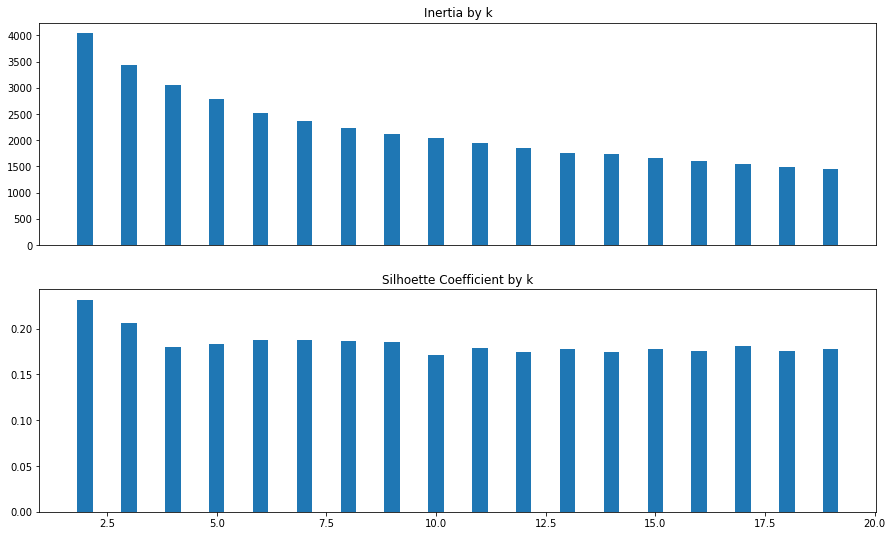

In [9]:
inert_k = []
sil_k = []

for k in range(2, 20):
    km = cluster.KMeans(n_clusters = k)
    km.fit(dpro)
    inert_k.append(km.inertia_)
    sil_k.append(metrics.silhouette_score(dpro, km.labels_, metric = 'euclidean'))    

fix = plt.figure(figsize = (15, 9))
ax1 = plt.subplot(211)
plt.bar(range(2,20), inert_k, 0.35)
plt.title('Inertia by k')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1 = plt.subplot(212)
plt.bar(range(2,20), sil_k, 0.35)
plt.title('Silhoette Coefficient by k')

plt.show()

We can determine the number $k$ through a study of metrics. Here we have inertia and silhouette scores. We can see that increasing $k$ tends to decrease the inertia. However silhouette score does not increase. 

One method for determining a value of $k$ is called elbow method. We look at the chart for inertia. We choose $k$ where the values start to become flat. 

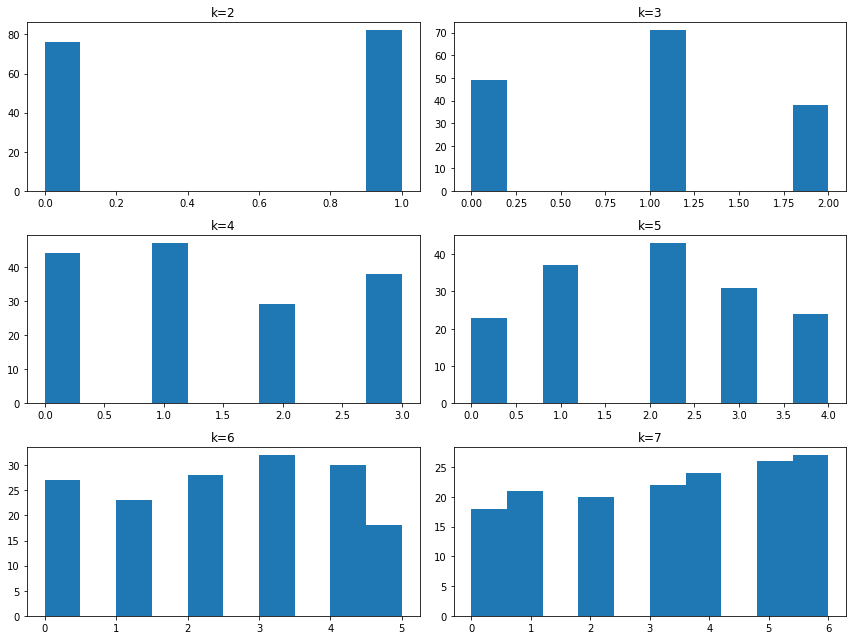

In [10]:
fig = plt.figure(figsize = (12, 9))
for k in range(2, 8):
    km = cluster.KMeans(n_clusters = k, init = 'k-means++', n_init = 5)
    km.fit(dpro)
    ax = fig.add_subplot(3, 2 , k - 1)
    plt.hist(km.labels_)
    plt.title('k={}'.format(k))

fig.tight_layout()

plt.show()

Here we have the distortion. We see that the clusters are balanced for all values of $k$. 

Now we can examine the centers of the clusters.

In [20]:
#Clustering on original X space
km = cluster.KMeans(n_clusters = 4)
km.fit(dpro)
cols = ['r', 'y', 'b', 'g']

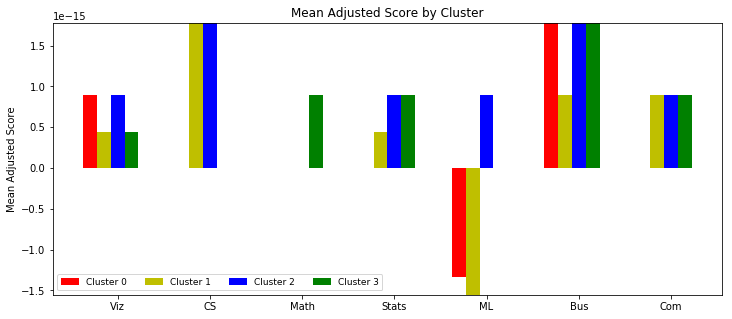

In [28]:
fig = plt.figure(figsize = (12, 5))
for i, cc in enumerate(km.cluster_centers_):
    w = 0.15
    ax = fig.add_subplot(1, 1, 1)
    temp = dpro_copy[dpro_copy["label"] == i]
    temp = temp.drop(columns=["label"])
    plt.bar(np.arange(len(cc)) + i*w, cc - temp.mean(), w, color = cols[i], label='Cluster {}'.format(i))
    ax.set_xticklabels(dpro.columns.values)
    ax.set_xticks(np.arange(len(cc))+2*w)

plt.ylabel('Mean Adjusted Score')
plt.title('Mean Adjusted Score by Cluster')
plt.legend(loc = 3, ncol = 4, prop={'size':9});

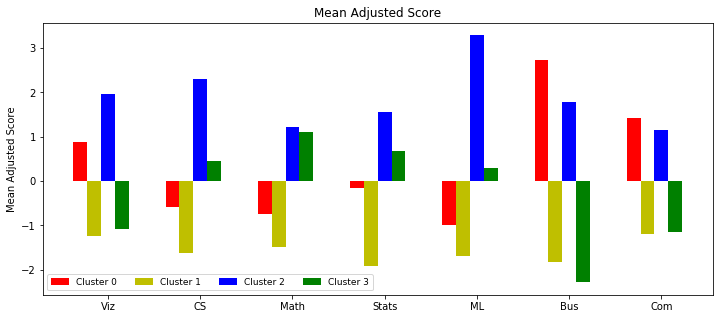

In [27]:
dpro_copy = dpro.copy()
dpro_copy["label"] = km.labels_

fig = plt.figure(figsize = (12, 5))
for i, cc in enumerate(km.cluster_centers_):
    w = 0.15
    ax = fig.add_subplot(1, 1, 1)
    plt.bar(np.arange(len(cc)) + i*w, cc - dpro.mean(), w, color = cols[i], label='Cluster {}'.format(i))
    ax.set_xticklabels(dpro.columns.values)
    ax.set_xticks(np.arange(len(cc))+2*w)

plt.ylabel('Mean Adjusted Score')
plt.title('Mean Adjusted Score')
plt.legend(loc = 3, ncol = 4, prop={'size':9});

In the above we chose $k=4$. Let's assume we did this because we want to assign employees to groups of 4 to work together on the task. Our goal would be to maximize the skill diversity of each group, so we would cluster into 4 clusters and assign one employee per cluster into each group. If we look at the above plots, we can get a sense of how the average person within each group differs from the average employee on the team. 

<b><u>Employee Profiles</u></b>
<ul>
    <li><u>Cluster 0</u> appears to be strongest in business, communication and vizualization. </li>
    <li><u>Cluster 1</u> is the math/stats group.</li>
    <li><u>Cluster 2</u> in general is the group that tends to rate itself low on all dimensions!</li>
    <li><u>Cluster 3</u> in general is the group that tends to be very confident on all technical subjects!</li>
    </ul>
</p>

#### Hierarchical 

In the above we showed how to compute and evaluate K-Means, and we also came up with a use case for the clustering. 

The above use case (i.e., putting employees into groups of size 4) essentially dictated the choice of $k$. In a more general use case, we might not have such an application specific best $k$. One way we can be more general is to use hiearchical clustering. 

In this type of clustering, the individual clusters are embedded in a taxonomy. We can use this taxonomy to see if there are any natural values of $k$ that make the most sense. We can also use it to ensure that each final cluster we choose is well balanced in size. Additionally, we can use this to get a sense of any outlier clusters (those with very small counts).

Using Scipy isn't as straightforward as using Sklearn, but again, scipy has a good procedure for displaying the dendrogram.

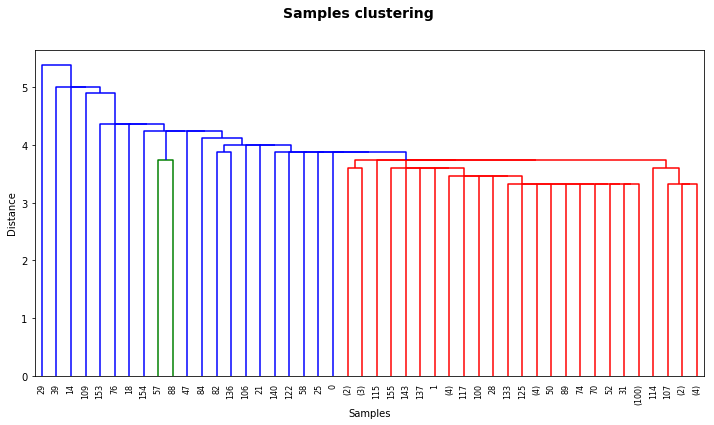

In [29]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

#This function gets pairwise distances between observations in n-dimensional space.
dists = pdist(dpro)

#This function performs hierarchical/agglomerative clustering on the condensed distance matrix y.
links = linkage(dists)

p = 46
#Now we want to plot the dendrogram
fig = plt.figure(figsize = (12, 6))
den = dendrogram(links, truncate_mode = 'lastp', p = p)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14);

plt.show()

<p>Let's try to understand the output of the linkage function. The first few records look like:
</p>

In [30]:
links[:5,:]

array([[ 16.        , 121.        ,   1.73205081,   2.        ],
       [ 93.        , 110.        ,   1.73205081,   2.        ],
       [ 13.        , 159.        ,   1.73205081,   3.        ],
       [ 35.        , 157.        ,   1.73205081,   2.        ],
       [ 92.        , 130.        ,   1.73205081,   2.        ]])

<p>The way we read this is as follows:
<ul>
    <li>At the lowest level, each record is assigned to its own cluster, and the cluster number is just its original index.</li>
    <li>The linkage function returns an (n-1) by 4 matrix where:</li>
        <ul>
            <li>The ith row corresponds to a new cluster, whose id=n+i</li>
            <li>The L[i,0] and L[i,1] columns are the two clusters that are joined to make cluster (n+i)</li>
            <li>The column L[i, 2] is the distance between L[i,0] and L[i,1]</li>
            <li>The last column is the final size of cluster (n+i)</li>
        </ul>
</ul><br>
In the above few rows, we see that user 19 and 30 were combined to make cluster 46. Then, we see in the 5th row that this cluster 46 was joined with user 0 to make cluster 50. If we look up at the dendrogram we can see these 3 students being combined into a single cluster.

</p>

In [31]:
ka = cluster.AgglomerativeClustering(n_clusters = 4)
ka.fit(dpro)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func='deprecated')

<p>Let's do another plot of mean adjusted centroids to get a sense of what each cluster represents. Sklearn.cluster.Ward does not return the centroids, so we'll have to compute this step ourselves.
</p>

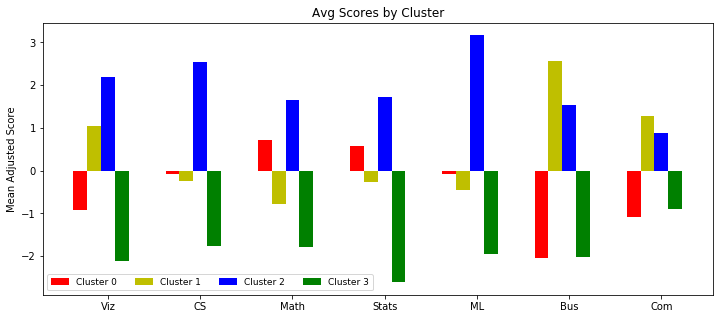

In [32]:
#Clustering on original X space using Hierarchical clustering

cols = ['r','y','b','g']

fig = plt.figure(figsize = (12, 5))
for i in range(4):
    w = 0.15
    ax = fig.add_subplot(1,1,1)
    cc = dpro[(ka.labels_==i)].mean()
    plt.bar(np.arange(len(cc))+i*w, cc - dpro.mean(), w, color = cols[i], label='Cluster {}'.format(i))
    ax.set_xticklabels(dpro.columns.values)
    ax.set_xticks(np.arange(len(cc))+2*w)

plt.ylabel('Mean Adjusted Score')
plt.title('Avg Scores by Cluster')
plt.legend(loc = 3, ncol = 4, prop={'size':9})

plt.show()
   

<p>When we plot the 4 clusters using hierarchical clustering, we get similar conceptual groupings as we did with k-means. However, I find this latter plot more easy to interpret (remember, this is a bit subjective).
<br><br>
<b><u>Employee Profiles using Hierarchical Clustering</u></b>
<ul>
    <li><u>Cluster 0:</u> This group has most of the math/stats experience</li>
    <li><u>Cluster 1:</u> These are the business and strategy minded employees. </li>
    <li><u>Cluster 2:</u> These are the math/stats folks in the group.</li>
    <li><u>Cluster 3:</u> This group is a little below average in skill across all categories (or at least is the group that underrates their own skill levels).</li>
</ul>

<br><br>
So now we have to make a choice - which clustering method to use for the employee profiles. One last thing to compare is the distribution of employees across clusters for each method.
</p>

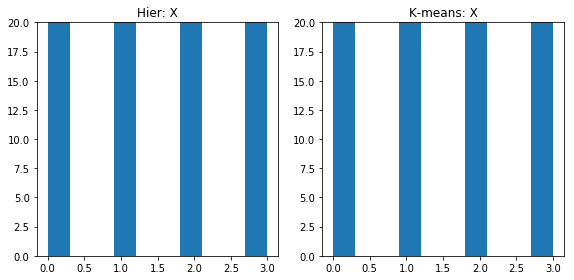

In [34]:

fig = plt.figure(figsize = (12, 4))

plt.subplot(1,3,1)
plt.hist(ka.labels_)
plt.ylim([0,20])
plt.title('Hier: X')

plt.subplot(1,3,2)
plt.hist(km.labels_)
plt.ylim([0,20])
plt.title('K-means: X')


fig.tight_layout()


plt.show()

<p>Comparing the above methods, we see fairly even representation in the clusters. Given this result, it is reasonable to choose the clustering method that gives us a more interpretable result. 
</p>